In [2]:
# code here
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
import matplotlib.pyplot as plt

import numpy as np
import theano.tensor as tt
import pymc3 as pm

deg = np.pi/180.0

In [1]:
def calc_theta(i_disk, Omega_disk, i_star, Omega_star):
    '''
    Calculate the mutual inclination between two planes. Assumes all inputs in degrees.
    '''
    
    cos_theta = np.cos(i_disk * deg) * np.cos(i_star * deg) + \
        np.sin(i_disk * deg) * np.sin(i_star * deg) * np.cos((Omega_disk - Omega_star) * deg)
    theta = np.arccos(cos_theta)/deg
    
    return theta

V4046 Sgr : $M \sin^3 i_\star = 0.2923 \pm 0.0007$ $M = 1.75 \pm 0.08\,M_\odot$ $i_\star = 33.42^\circ \pm 0.58^\circ$ and $i_\mathrm{disk} = 33.5^\circ \pm 1.4^\circ$ 

AK Sco: $M \sin^3 i_\star = 2.114 \pm 0.01\,M_\odot$, $M = 2.49\pm 0.10\,M_\odot$

DQ Tau: $M \sin^3 i_\star = 0.0647 \pm 0.0033\,M_\odot$. $M = 1.27^{+0.46}_{-0.27}\,M_\odot$

UZ Tau E: $M \sin^3 i_\star = 0.75 \pm 0.10$ $M = 1.21 \pm 0.09\,M_\odot$

Let $x = M \sin^3 i_\star$.

$$
i_\star = \sin^{-1} \left [\left ( \frac{x}{M} \right)^{1/3} \right ]
$$

In [51]:
# MC code to convert uncertainty on M sin^3 i and M to uncertainty on i_star
xs = np.random.normal(loc=0.2923, scale=0.0007, size=10000)
Ms = np.random.normal(loc=1.75, scale=0.08, size=10000)
q = (xs/Ms)**(1/3)
j = q[(q > -1) & (q < 1)]
i_stars = np.arcsin(j)/deg

0.5858374106073172


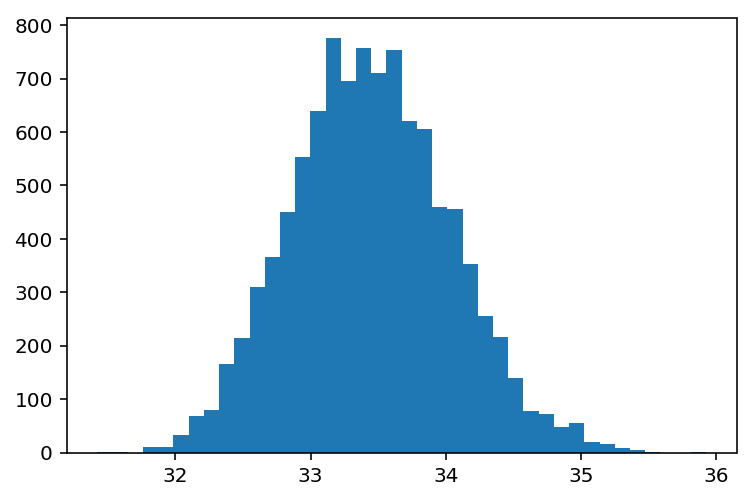

In [52]:
print(np.std(i_stars))
plt.hist(i_stars, bins=40);

In [25]:
def get_i_star(M, M_err, x, x_err):
    i_star = np.arcsin((x/M)**(1/3))/deg
        
    return i_star
                 
print(get_i_star(2.49, 0.10, 2.114, 0.01))
print(get_i_star(1.27, 0.35, 0.0647, 0.0033))
print(get_i_star(1.21, 0.09, 0.75, 0.10))

71.24376075661917
21.759370328104644
58.49845953759619


In [53]:
# create tables of all of these things as datasets
from astropy.table import Table

# table of stars with inclinations and uncertainties
# name, #i_disk, i_disk_err, i_star, i_star_err (deg)
rows = [("V4046Sgr", 33.5, 1.4, 33.42, 0.58),
("AKSco", 109.4, 0.5, 108.76, 2.4 ),
("DQ Tau", 160.0, 3.0, 158.24, 2.77),
("UZ Tau E", 56.15, 1.5, 58.6, 5.0)]

sample = Table(rows=rows, names=["name", "i_disk", "i_disk_err", "i_star", "i_star_err"])

In [54]:
sample

name,i_disk,i_disk_err,i_star,i_star_err
str8,float64,float64,float64,float64
V4046Sgr,33.5,1.4,33.42,0.58
AKSco,109.4,0.5,108.76,2.4
DQ Tau,160.0,3.0,158.24,2.77
UZ Tau E,56.15,1.5,58.6,5.0


In [55]:
sd_disk = np.sin(sample["i_disk"].data * deg) * sample["i_disk_err"].data * deg
sd_star = np.sin(sample["i_star"].data * deg) * sample["i_star_err"].data * deg
N_systems = 4

In [66]:
# instantiate a PyMC3 model class 
with pm.Model() as model:
    
    # Technically because the hyperparameters of the Beta distribution are parameters in the model,
    # we also have priors on these values, called hyperpriors. 
    # For now, we'll just asssume a uniform range over the values we plotted up earlier.
    # We'll come back with something more intelligent later.
    # These specify that alpha and beta are random variables to be drawn from a uniform distribution.
    log_alpha = pm.Uniform("logAlpha", lower=0.0, upper=3.0)
    log_beta = pm.Uniform("logBeta", lower=0.0, upper=3.0)

    # The Beta distribution described by these parameters (p_\Beta) will be used for all systems in the sample
    
    # Now, we consider the parameters for individual systems
    # The mutual inclination for any particular system is drawn from the distribution set by these parameters.
    # But, see how the distribution is set by the random variables alpha and beta? 
    # From this distribution, we draw one intermediate mutual inclination variable x for each system
    x = pm.Beta("x", alpha=10**log_alpha, beta=10**log_beta, shape=N_systems)    

    # Convert from the intermediate variable to the actual mutual inclination angle we want
    cos_theta = pm.Deterministic("cos_theta", 1 - 2 * x)
    
    # Enforce the geometrical prior on i_disk, as before
    # Testval tells the chain to start in the center of the posterior.
    cos_i_disk = pm.Uniform("cosIdisk", lower=-1.0, upper=1.0, shape=N_systems, testval=np.cos(sample["i_disk"].data * deg)) 
    
    # This is the azimuthal orientation of the binary vector on the circle some theta away 
    phi = pm.Uniform("phi", lower=-np.pi/2.0, upper=np.pi/2.0, shape=N_systems)

    # Now, we will use cos_i_disk, Delta_I, and phi to calculate cos_i_star
    sin_i_disk = tt.sqrt(1.0 - cos_i_disk**2)
    sin_theta = tt.sqrt(1.0 - cos_theta**2)
    
    cos_i_star = pm.Deterministic("cos_i_star", -sin_i_disk * sin_theta * tt.sin(phi) + \
                                  cos_i_disk * cos_theta)
    
    # Finally, we define the likelihood by conditioning on the observations using a Normal
    obs_disk = pm.Normal("obs_disk", mu=cos_i_disk, sd=sd_disk, observed=np.cos(sample["i_disk"].data * deg))
    obs_star = pm.Normal("obs_star", mu=cos_i_star, sd=sd_star, observed=np.cos(sample["i_star"].data * deg))

In [71]:
# try finding the MAP first
with model:
    map_params = pm.find_MAP()

logp = 42.487, ||grad|| = 0.056138: 100%|██████████| 138/138 [00:00<00:00, 956.95it/s] 


In [77]:
# sample the model!
with model:
    trace = pm.sample(draws=5000, tune=60000, start=map_params, chains=2, nuts_kwargs={"target_accept":0.99})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [phi, cosIdisk, x, logBeta, logAlpha]
Sampling 2 chains: 100%|██████████| 130000/130000 [13:28<00:00, 84.66draws/s] 
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


(<matplotlib.axes._subplots.AxesSubplot at 0x1c4ab629b0>, GridSpec(21, 21))

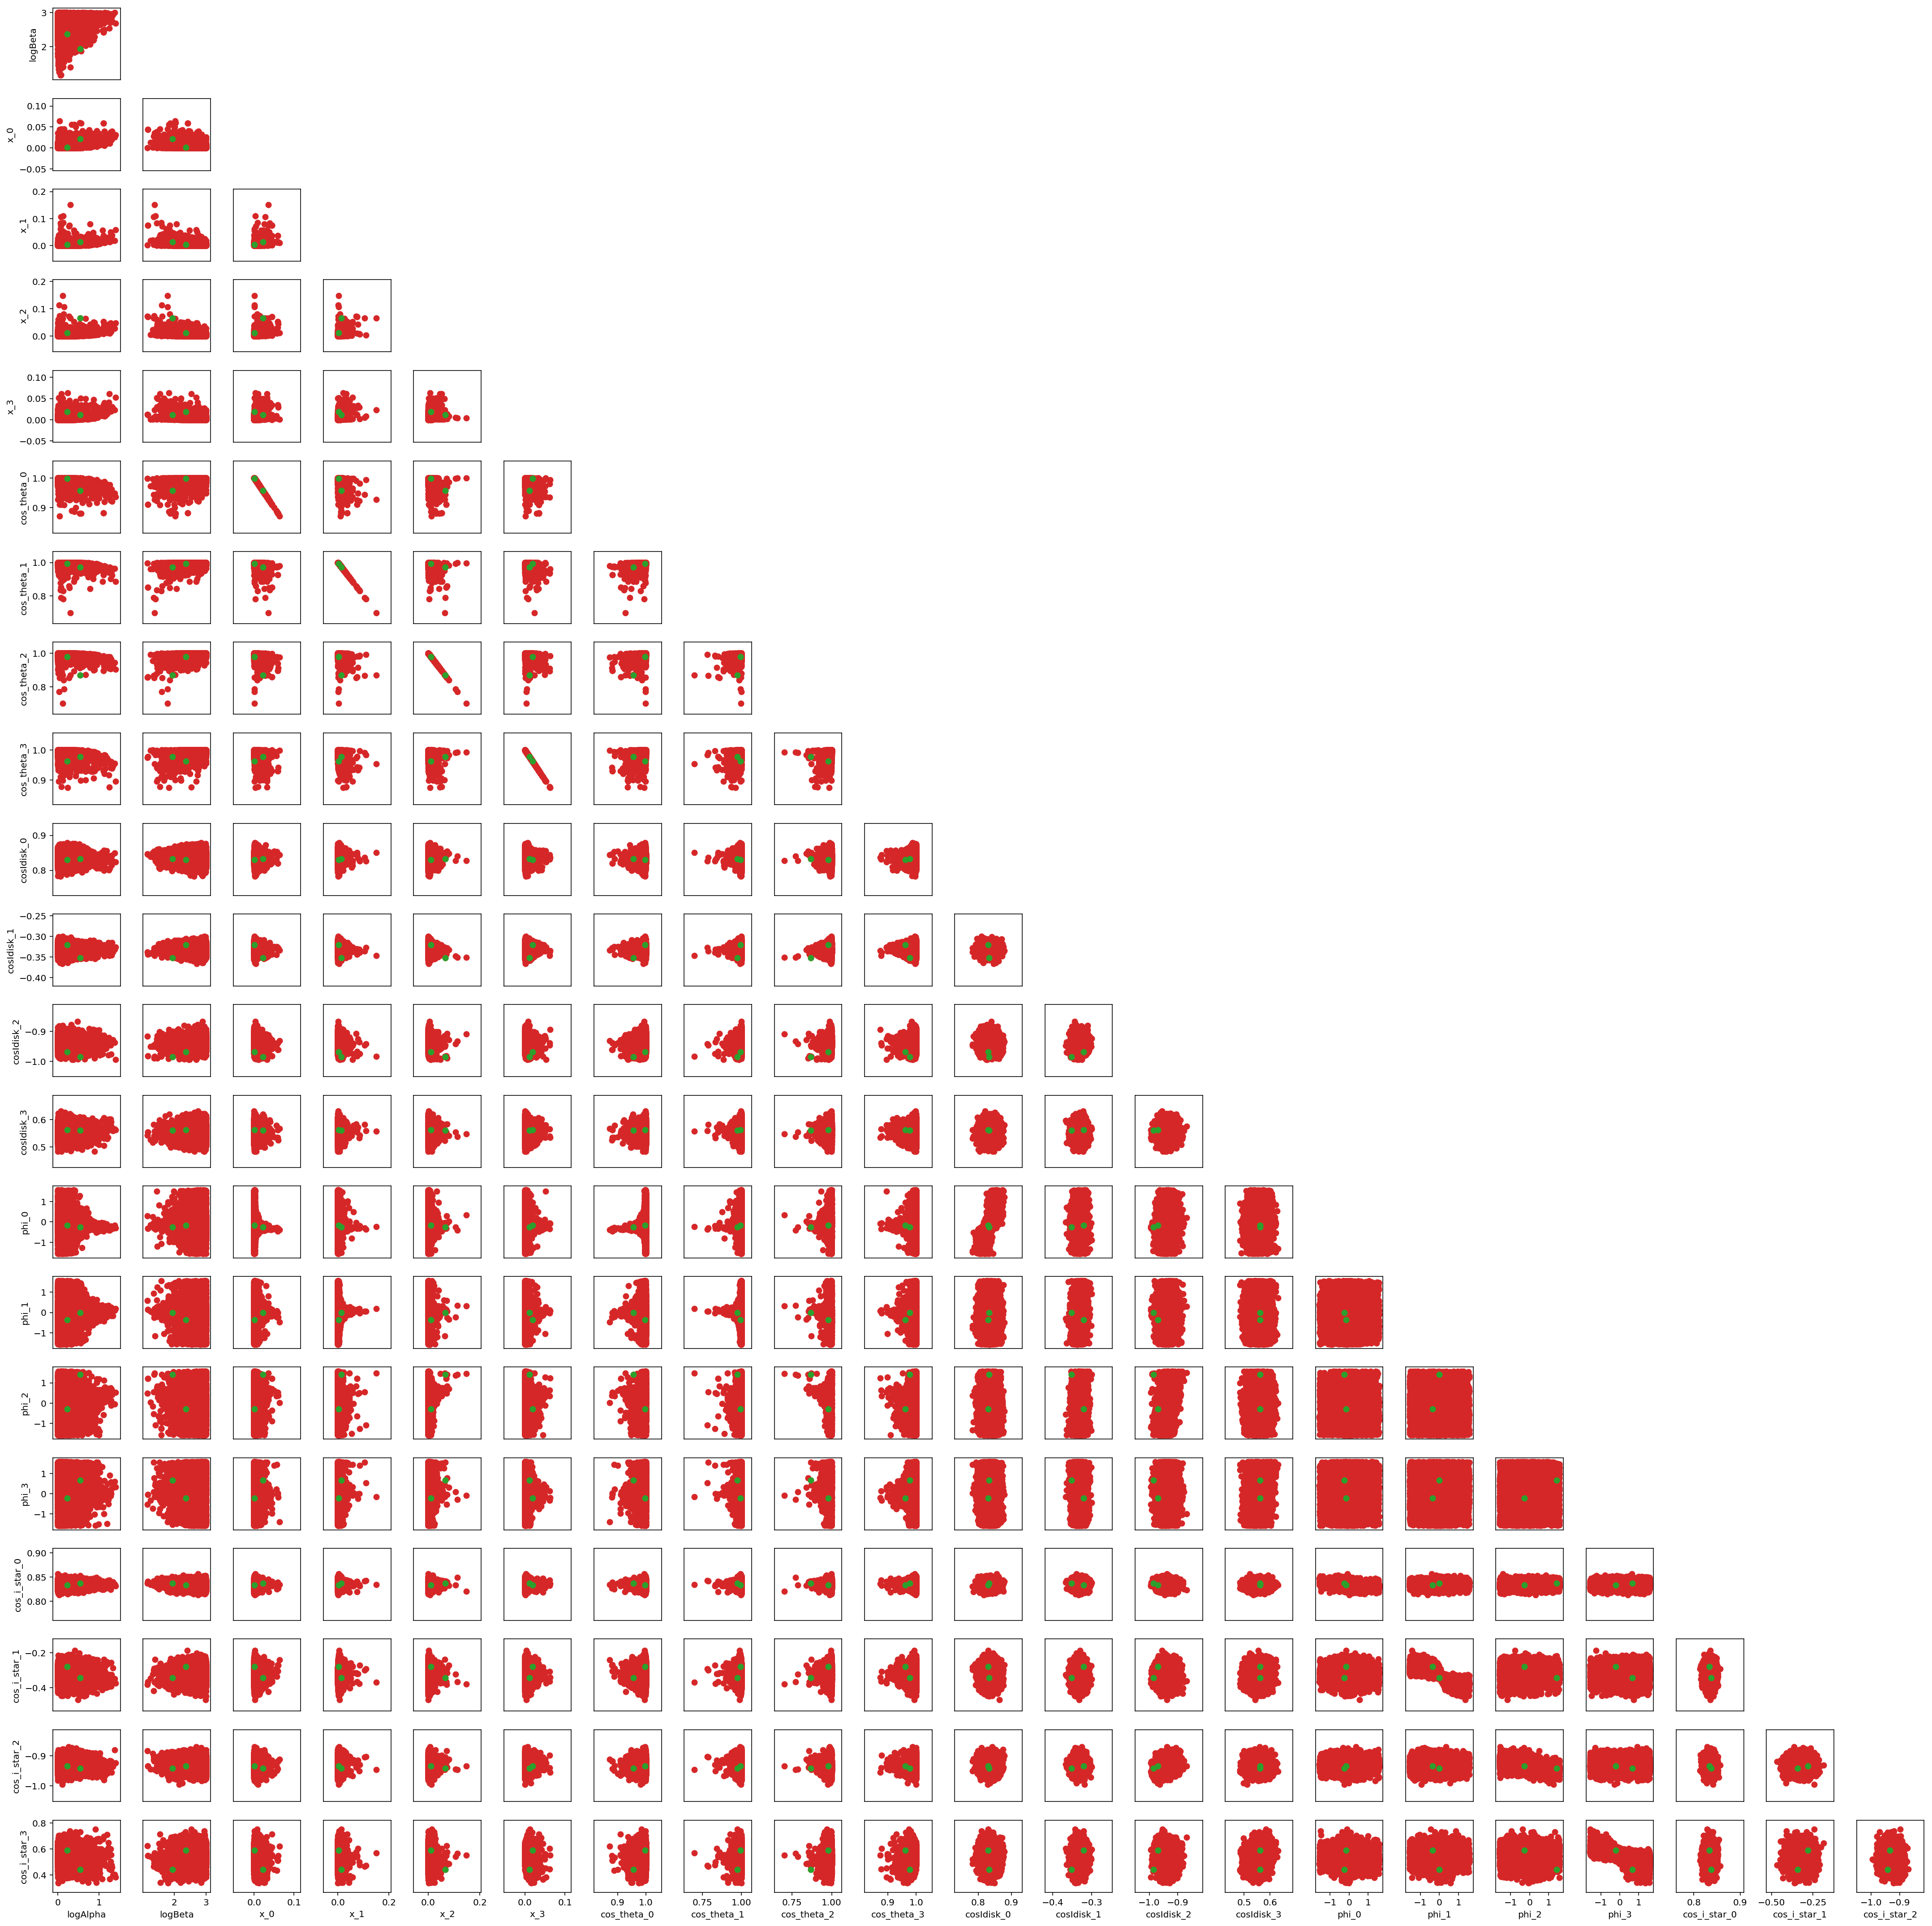

In [74]:
pm.pairplot(trace,
#             sub_varnames=[variable_1, variable_2],
            divergences=True,
            color='C3',
            kwargs_divergence={'color': 'C2'})

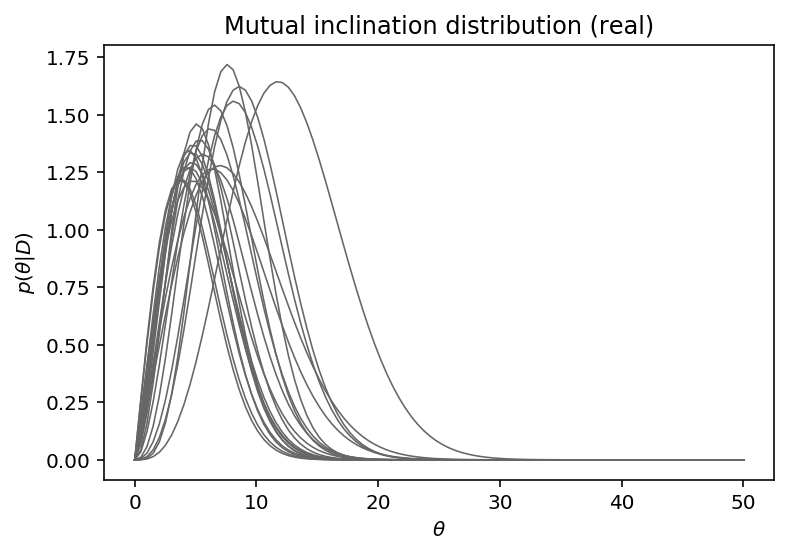

In [82]:
N_realizations = 20

N_samples = len(trace)
ind = np.random.choice(range(N_samples), size=N_realizations)
alphas = 10** trace["logAlpha"][ind]
betas = 10**trace["logBeta"][ind]

thetas = np.linspace(0, 50, num=100)
xs = 0.5 * (1.0 - np.cos(thetas * deg))

fig, ax = plt.subplots(nrows=1)

for (alpha, beta) in zip(alphas, betas):
    y = pm.Beta.dist(alpha=alpha, beta=beta) # query the PyMC3 implementation
    ys = np.exp(0.5 * np.array([y.logp(x).eval() for x in xs])) * np.sin(thetas * deg)
    
    ax.plot(thetas, ys, lw=0.8, color="0.4")
    
ax.set_xlabel(r"$\theta$");
ax.set_ylabel(r"$p(\theta|D)$");
ax.set_title("Mutual inclination distribution (real)");

/Users/ianczekala/.build/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


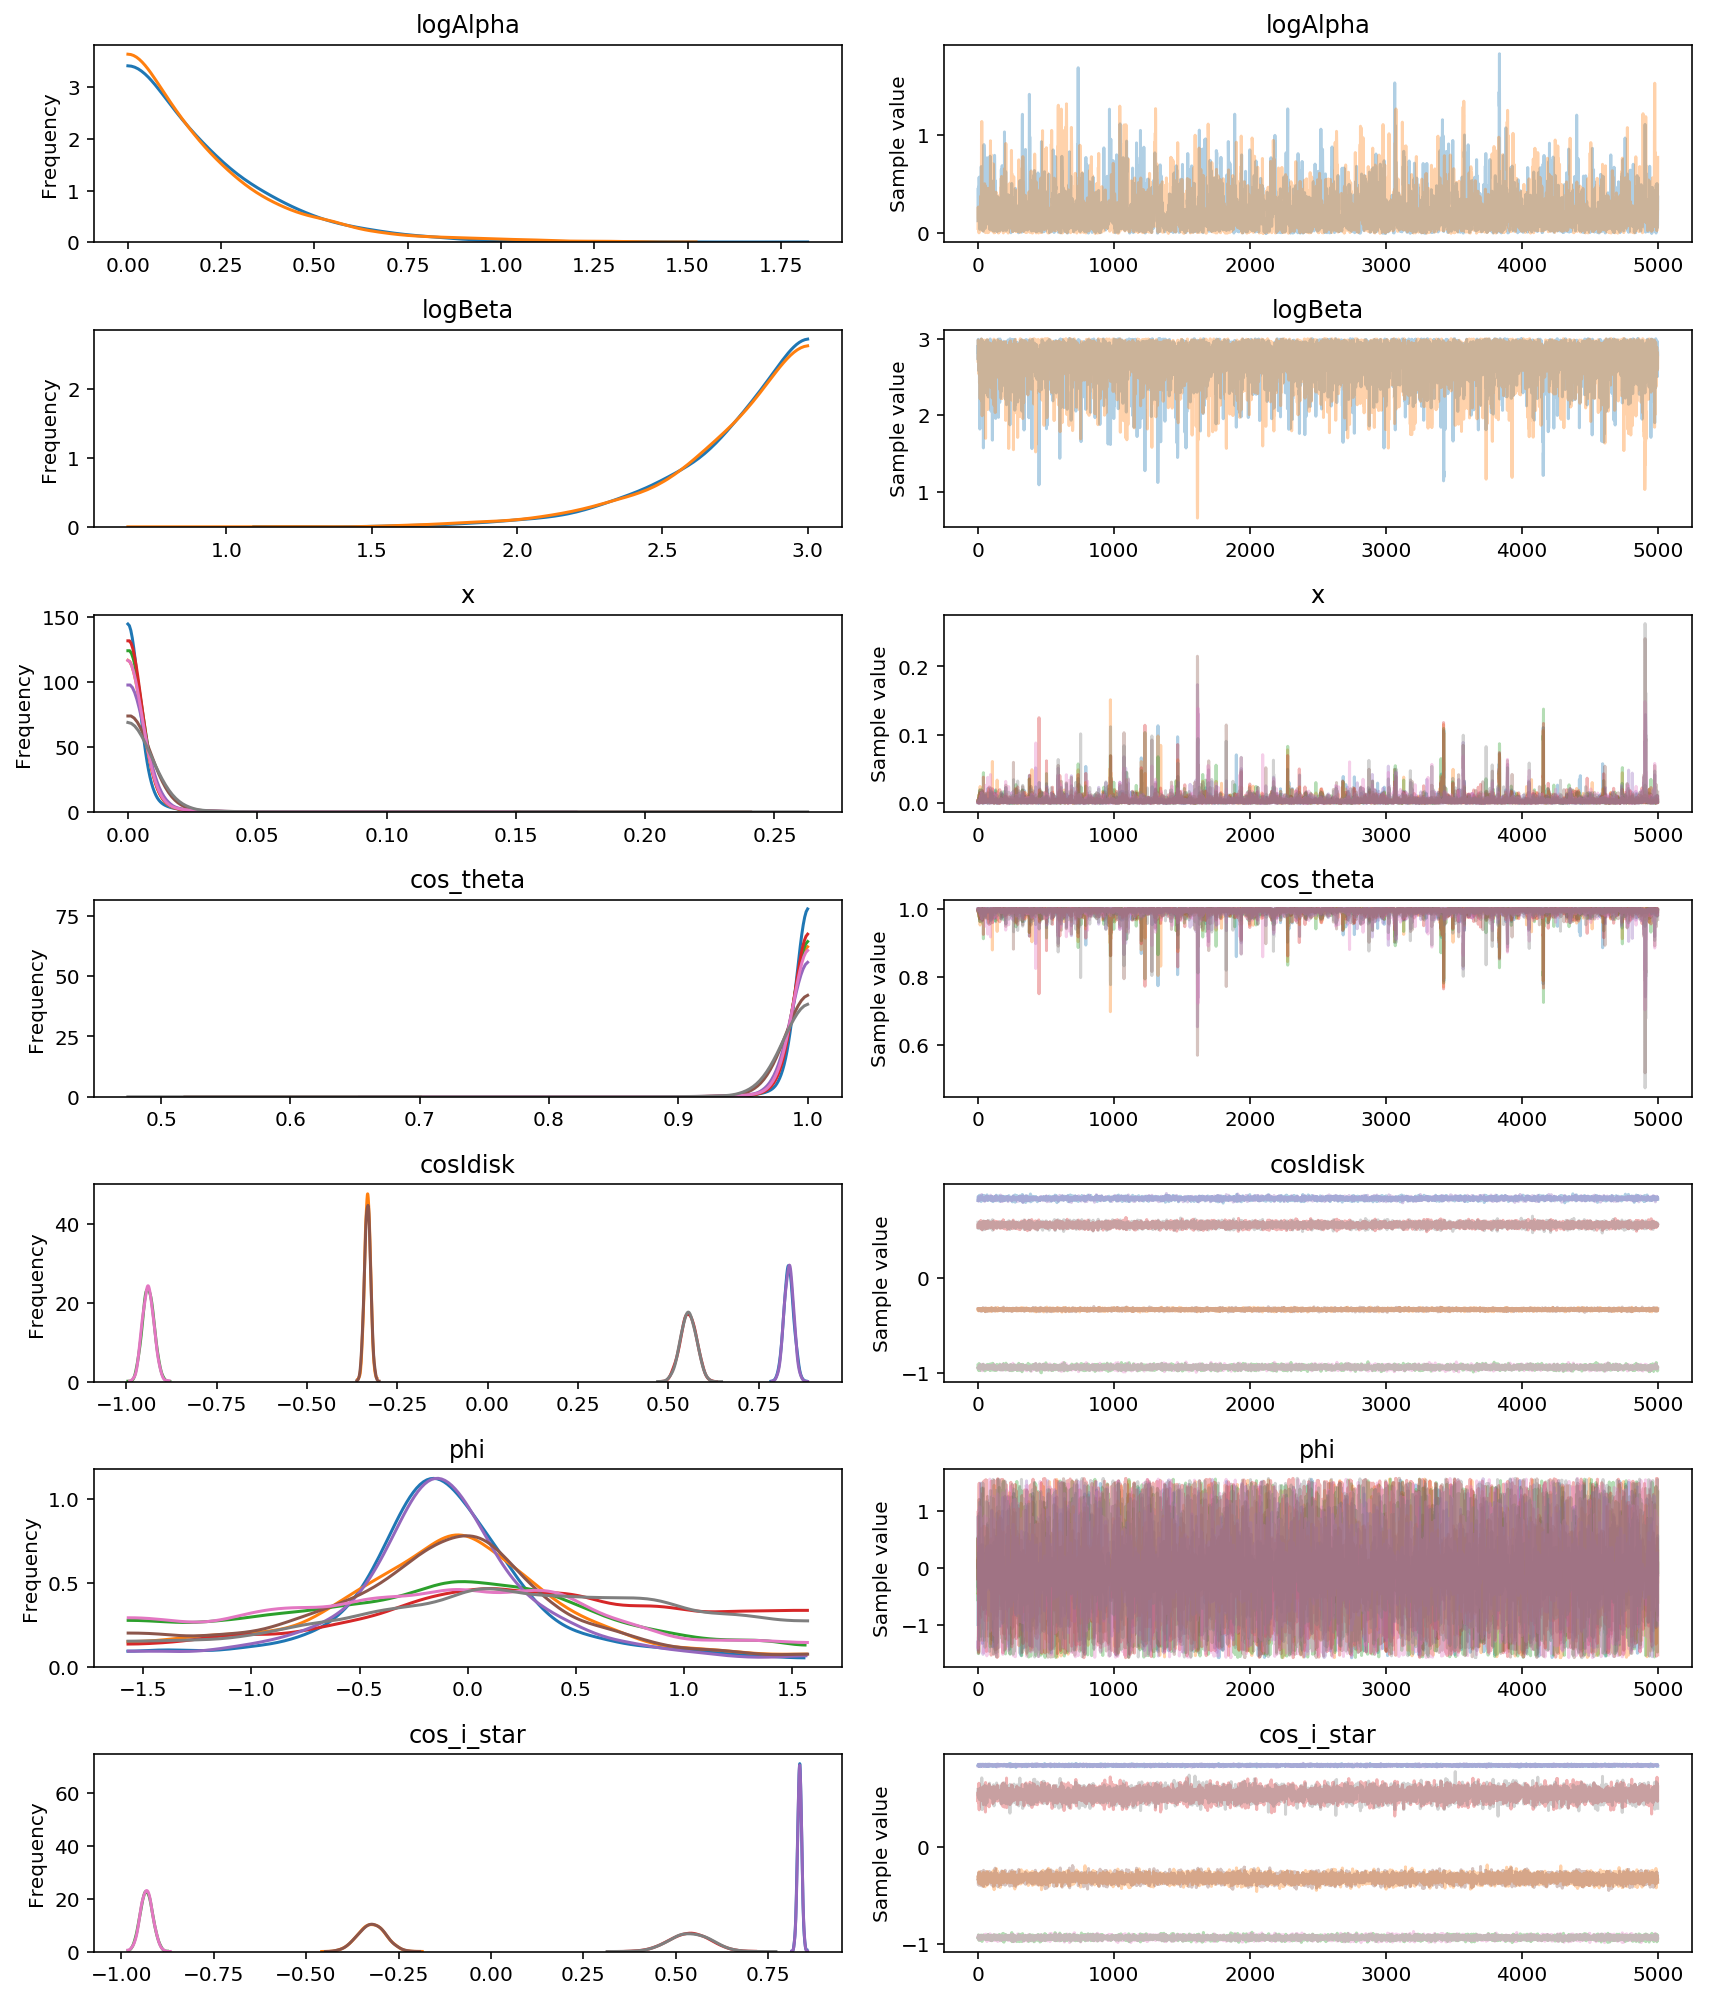

In [81]:
pm.traceplot(trace);